# Embedding dimension

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
import time
from tqdm import tqdm

from graph_generation import create_ER
from models import GCN, GCNEmbed, GCN1n
from train import Trainer
from embedding import Embedding

import torch
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

import yaml

In [3]:
config = yaml.safe_load(open("configs.yml"))

In [4]:
N = config['graph_dataset']['Num_nodes']
p1 = config['graph_dataset']['p1ER']
p2 = config['graph_dataset']['p2ER']
Num_grafi_per_tipo = config['graph_dataset']['Num_grafi_per_tipo']

grafi_0 = create_ER(N, p1, Num_grafi_per_tipo)
grafi_1 = create_ER(N, p2, Num_grafi_per_tipo)
dataset_grafi_nx = grafi_0 + grafi_1
#dataset_labels = np.array([0]*len(grafi_0) + [1]*len(grafi_1))
# adesso le labels corrispondono proprio al valore della probabilità
dataset_labels = np.array([p1]*len(grafi_0) + [p2]*len(grafi_1))


def experiment_embedding():
    config = yaml.safe_load(open("configs.yml"))
    if config['device'] == 'gpu':
        device = torch.device('cuda')
    else:
        device = "cpu"

    model = GCN1n(hidden_channels=config['model']['num_neurons'])
    model.to(device)
    #print(model)
    
    trainer = Trainer(model, config)
    print("Loading Dataset...")
    trainer.load_dataset(dataset_grafi_nx, dataset_labels, percentage_train=config['training']['percentage_train'])
    train_loss_list, test_loss_list = trainer.launch_training()
    
    # get embedding of all graphs in dataset
    embed_model = GCNEmbed(model)
    embed_model = embed_model.to(device)
    whole_data = trainer.dataset.dataset_pyg
    all_data_loader = DataLoader(whole_data, batch_size=trainer.dataset.len_data, shuffle=False)
    batch = next(iter(all_data_loader))
    embeddings_array = embed_model(batch.x, batch.edge_index, batch.batch).cpu().detach().numpy()
    
    embeddings = Embedding(embeddings_array, trainer.dataset.labels, (p1,p2), test_loss_list)
    embeddings.calc_coppie()
    embeddings.calc_distances()
    
    return embeddings

Mean connectivity for each node: 29.643
Mean connectivity for each node: 7.919


In [5]:
embeddings = experiment_embedding()

Loading Dataset...


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 116.41it/s]


Tempo impiegato: 1.734114170074463
runs/lr-0.005_epochs1500_bs150_layers3_neurons64_lln1/04May_19-48-37


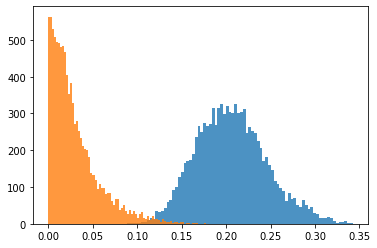

In [10]:
plt.hist(embeddings.inter_dists, bins=80, alpha=0.8)
plt.hist(embeddings.intra_dists, bins=80, alpha=0.8)
plt.show()

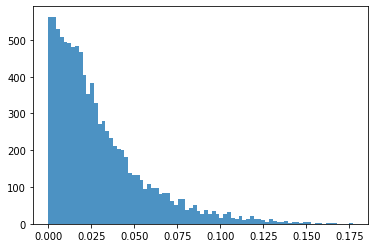

In [14]:
#plt.hist(embeddings.cos_inter_dists, bins=80, alpha=0.8)
plt.hist(embeddings.intra_dists, bins=80, alpha=0.8)
plt.show()

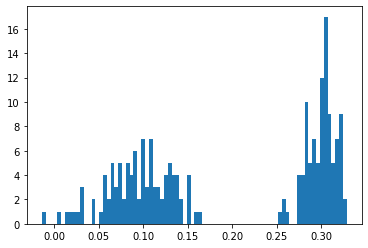

In [9]:
plt.hist(embeddings.embeddings_array, bins=80);